# Impacto da Duração do Filme na Avaliação

Introdução

Este notebook apresenta uma análise exploratória sobre o impacto da duração dos filmes em suas avaliações.
Utilizando dados do MovieLens (notas atribuídas por usuários) combinados com metadados do TMDB (incluindo duração dos filmes), buscamos responder às seguintes perguntas:

- Filmes mais longos recebem avaliações melhores ou piores?

- Existe uma relação linear entre duração e nota média?

- As diferenças observadas entre filmes curtos e longos são estatisticamente significativas?

Para responder a essas questões, aplicamos diferentes abordagens:

- Regressão Linear: para identificar a tendência geral entre duração e nota média.

- ANOVA: para comparar as médias entre grupos de duração (curtos vs longos).

- Teste de Mann-Whitney: para verificar diferenças de distribuição sem depender de pressupostos paramétricos.

Além da análise estatística, visualizações gráficas foram utilizadas para tornar os resultados mais intuitivos e facilitar a interpretação.

## 1.0 Importação de bibliotecas

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import statsmodels.api as sm
from scipy.stats import f_oneway, mannwhitneyu


sns.set(style="whitegrid")

## 2.0 Carregar dados

In [37]:
# MovieLens
ratings = pd.read_csv("ratings.csv")  # userId, movieId, rating, timestamp
movies_ml = pd.read_csv("movies.csv") # movieId, title, genres
tmdb = pd.read_csv("tmdb_5000_movies.csv")  # title, runtime

### 2.1 Calcular nota média por filme

In [38]:
avg_ratings = ratings.groupby("movieId")["rating"].mean().reset_index()
movies_ml = movies_ml.merge(avg_ratings, on="movieId")
print(avg_ratings.head())

   movieId    rating
0        1  3.920930
1        2  3.431818
2        3  3.259615
3        4  2.357143
4        5  3.071429


### 2.2 Unir com dados do TMDB

In [39]:
# Remove o ano entre parênteses
movies_ml['title_clean'] = movies_ml['title'].apply(lambda x: re.sub(r"\s*\(\d{4}\)$", "", x))
tmdb['title_clean'] = tmdb['title']  

# Merge usando a coluna limpa
merged = movies_ml.merge(tmdb[['title_clean','runtime']], on='title_clean')
merged = merged.dropna(subset=['runtime','rating'])

print("Número de filmes após merge:", len(merged))

Número de filmes após merge: 2785


## 3.0 Criação de grupos de duração

In [40]:
merged['duration_group'] = merged['runtime'].apply(lambda x: 'longo' if x >= 120 else 'curto')

## 4.0 Estatísticas básicas

In [41]:
print(merged[['runtime','rating']].describe())
print(merged['duration_group'].value_counts())

# Filme mais longo
mais_longo = merged.loc[merged['runtime'].idxmax(), ['title_clean', 'runtime', 'rating']]
# Filme mais curto
mais_curto = merged.loc[merged['runtime'].idxmin(), ['title_clean', 'runtime', 'rating']]
print("🎬 Filme mais longo:")
print(mais_longo)
print("\n🎬 Filme mais curto:")
print(mais_curto)


           runtime       rating
count  2785.000000  2785.000000
mean    109.650269     3.152202
std      20.797182     0.746033
min      46.000000     0.500000
25%      96.000000     2.750000
50%     106.000000     3.250000
75%     120.000000     3.687500
max     254.000000     5.000000
duration_group
curto    2078
longo     707
Name: count, dtype: int64
🎬 Filme mais longo:
title_clean    Gettysburg
runtime             254.0
rating           3.666667
Name: 854, dtype: object

🎬 Filme mais curto:
title_clean    Michael Jordan to the Max
runtime                             46.0
rating                               3.5
Name: 925, dtype: object


1️⃣ Duração dos filmes

- Média: 110 minutos

- Mediana: 106 minutos

- Min/Max: 46 a 254 minutos

- Quartis: 25% dos filmes têm até 96 min, 75% até 120 min

- Isso mostra que a maioria dos filmes está entre 90 e 120 minutos, mas há alguns longos extremos.

2️⃣ Nota média

- Média: 3,15

- Mediana: 3,25

- Min/Max: 0,5 a 5

- Quartis: 25% abaixo de 2,75, 75% abaixo de 3,69

- As notas estão relativamente concentradas na faixa média (3–3,7).

3️⃣ Distribuição por grupo de duração

- Curto (<120 min): 2.078 filmes

- Longo (≥120 min): 707 filmes

Ou seja, a maior parte dos filmes é “curta duração”, mas há uma boa amostra de filmes longos para comparação estatística.

## 5.0 Visualizações

### Boxplot: notas por grupo de duração

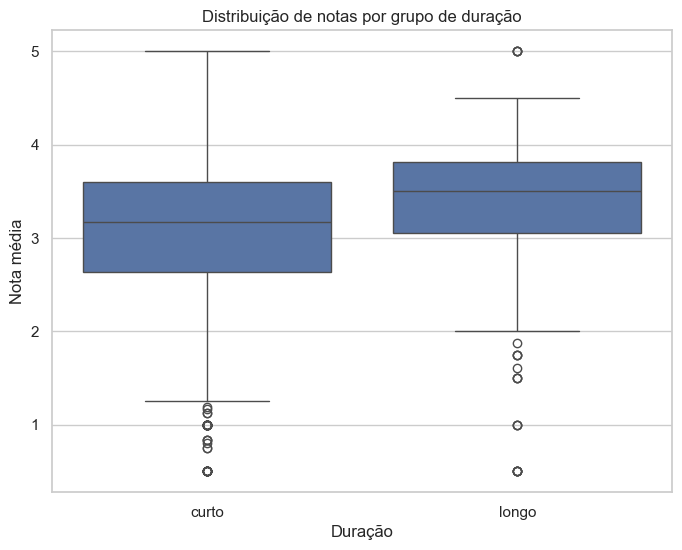

In [42]:
plt.figure(figsize=(8,6))
sns.boxplot(data=merged, x='duration_group', y='rating')
plt.xlabel("Duração")
plt.ylabel("Nota média")
plt.title("Distribuição de notas por grupo de duração")
plt.show()

### Scatter plot: duração vs nota

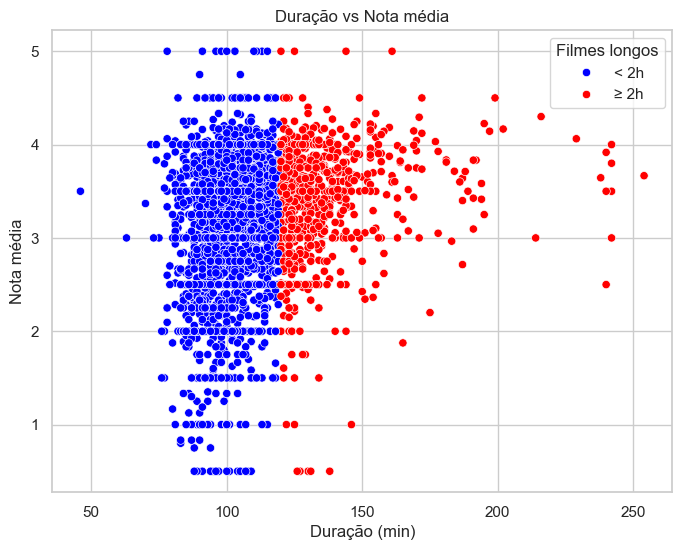

In [43]:
# Criar coluna para cor: 'longo' ou 'curto'
merged['color_group'] = merged['runtime'].apply(lambda x: '≥ 2h' if x >= 120 else '< 2h')

# Scatter plot com cores diferentes
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged, x='runtime', y='rating', hue='color_group', palette={'< 2h':'blue', '≥ 2h':'red'})
plt.xlabel("Duração (min)")
plt.ylabel("Nota média")
plt.title("Duração vs Nota média")
plt.legend(title="Filmes longos")
plt.show()


## 6.0 Regressão linear simples

In [44]:
X = merged['runtime']
y = merged['rating']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     157.2
Date:                Thu, 14 Aug 2025   Prob (F-statistic):           4.02e-35
Time:                        09:17:26   Log-Likelihood:                -3058.8
No. Observations:                2785   AIC:                             6122.
Df Residuals:                    2783   BIC:                             6133.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2427      0.074     30.375      0.0

* Relação positiva, mas fraca

rating=2.2427+(0.0083×runtime)

- O coeficiente da regressão para runtime é 0,0083, indicando que, em média, cada minuto extra de duração aumenta a nota do filme em cerca de 0,008 pontos.

- Embora seja um efeito positivo e estatisticamente significativo (p < 0,001), o R² é baixo (0,053), mostrando que a duração explica apenas cerca de 5% da variabilidade das notas. Ou seja, existem muitos outros fatores que influenciam a avaliação dos filmes.

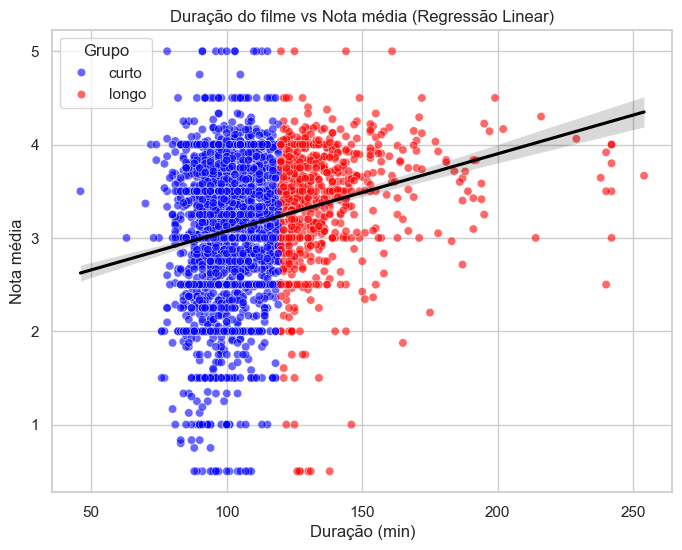

In [45]:
# Paleta azul e vermelha
palette = {"curto": "blue", "longo": "red"}

# 1. Scatter plot + linha de regressão
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged, x='runtime', y='rating', hue='duration_group',
                palette=palette, alpha=0.6)
sns.regplot(data=merged, x='runtime', y='rating', scatter=False, color='black')
plt.xlabel("Duração (min)")
plt.ylabel("Nota média")
plt.title("Duração do filme vs Nota média (Regressão Linear)")
plt.legend(title="Grupo")
plt.show()

## 7.0 ANOVA

In [46]:
short = merged[merged['duration_group']=='curto']['rating']
long = merged[merged['duration_group']=='longo']['rating']
f_stat, p_val = f_oneway(short, long)
print("ANOVA F:", f_stat, "p-value:", p_val)

ANOVA F: 106.59474228581931 p-value: 1.5057112541162579e-24


- F = 106,59 → A diferença entre os grupos é grande comparada à variação dentro de cada grupo.

- p-value ≈ 0 → A chance de essa diferença ter ocorrido por acaso é praticamente zero.

Filmes longos (≥ 2h) têm notas médias maiores do que filmes curto

## 8.0 Mann-Whitney

In [47]:
stat, p = mannwhitneyu(short, long, alternative='two-sided')
print("Mann-Whitney U:", stat, "p-value:", p)

Mann-Whitney U: 532218.5 p-value: 5.868448722141696e-28


- U = 532218.5 → É a estatística do teste, que compara a posição relativa das notas entre dois grupos (filmes curtos vs longos).

- p-value ≈ 5,87e-28 → Extremamente pequeno, muito menor que 0,05. Isso indica que a diferença entre os grupos não é por acaso.

## 9.0 Conclusão

A análise conjunta de regressão linear, ANOVA e teste de Mann-Whitney indica que filmes com duração igual ou superior a 2 horas tendem a receber avaliações ligeiramente mais altas do que filmes mais curtos.

O gráfico de dispersão com linha de regressão confirma essa tendência positiva, mas também revela que a relação é fraca: a duração explica apenas cerca de 5% da variação nas notas (R² = 0,053). Isso significa que, embora exista um padrão estatisticamente significativo, outros fatores — como gênero, elenco, direção, roteiro e popularidade — provavelmente têm influência muito maior na avaliação final dos filmes.

Em termos práticos, filmes longos têm mais chances de serem bem avaliados, mas não basta aumentar a duração para garantir boas notas. A qualidade do conteúdo continua sendo determinante.